In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA      = Path('data')
RAW       = DATA/'raw'
INTERIM   = DATA/'interim'
PROCESSED = DATA/'processed'

In [3]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
market     = pd.read_csv(RAW/'Market.csv', low_memory=False)
macro      = pd.read_csv(RAW/'MarketData_Macro.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [4]:
macro.head()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
0,20150101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.20,0.116959,0.81620,0.377658,0.861030,1.006264,0.161512,0.163399,1.2101,1.55775,0.128941,0.000081,0.008341,0.133451,0.756287,0.428964,0.086457,35.230452,2.724540,1.303309,-0.063143,3.701588,3.617925,0.077487,0.561227,0.381829,7.17183,0.112078,1.459648,0.709986,10.001685,0.256570,6.130798,19.989643,29.980614,21.985733,3.041150,2.398950,3.625076,2.558248,NaN,NaN,NaN,2.277279,NaN,2.760043,1.775859,0.409878,NaN,1.082563,-0.046046,3.749868,3.418686,NaN,3.549519,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.697389,NaN,1.408397,0.233572,NaN,NaN,NaN,NaN,2.252274,0.95467,NaN,1.814259,8.955845,8.368177,9.552123,8.708471,0.444559,NaN,1.233032,0.180984,1.806932,NaN,2.179804,1.295793,NaN,NaN,NaN,NaN,9.885583,10.069276,9.915120,2.295037,NaN,2.712112,1.774452,7.963276,6.856526,8.331874,7.403867
1,20150102,NaN,9764.73,3139.44,26.2531,6547.80,23857.82,NaN,17832.99,2058.20,17.79,0.116891,0.81140,0.371292,0.851136,0.998851,0.161186,0.163292,1.2008,1.53340,0.128934,0.000080,0.008308,0.131841,0.752757,0.427241,0.085609,33.000000,2.736281,1.302850,-0.063000,3.701588,3.617925,0.077179,0.563380,0.385000,7.10000,0.112078,1.490000,0.790000,10.020000,0.255218,6.125000,20.000000,30.000000,22.000000,3.108394,2.452905,3.692179,2.625847,11.767860,12.807338,12.202677,2.231223,1.445105,2.716551,1.748069,0.367391,NaN,1.040147,-0.058452,3.750081,3.419989,NaN,3.550031,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.640191,0.062120,1.347191,0.211268,1.674890,0.810358,2.109754,1.305976,2.290000,0.97500,2.751960,1.840000,8.950000,8.350000,9.550000,8.700000,0.444559,NaN,1.233032,0.180984,1.794443,1.100220,2.168744,1.280511,2.447394,1.132505,2.951900,1.948474,9.946260,10.151881,9.976101,2.236910,0.893242,2.647499,1.746344,7.940000,6.840000,8.310000,7.390000
2,20150105,3350.519,9473.16,3023.14,29.6236,6417.16,23721.32,17408.71,17501.65,2020.58,19.92,0.116782,0.80905,0.366757,0.850268,0.993764,0.160822,0.163265,1.1939,1.52555,0.128926,0.000079,0.008366,0.131277,0.749260,0.429304,0.085426,32.000000,2.742523,1.303171,-0.063000,3.749732,3.691439,0.075252,0.563380,0.383570,7.10000,0.112140,1.450000,0.875000,9.993400,0.254194,6.125000,20.000000,30.000000,22.000000,3.007227,2.423082,3.591836,2.566016,11.809585,12.736379,12.154331,2.180266,1.420899,2.668708,1.713829,0.350011,-0.263049,0.981356,-0.069792,3.700010,3.405070,NaN,3.500016,3.700010,3.405070,NaN,3.500016,3.450010,3.230070,NaN,3.250016,0.658914,0.063256,1.351414,0.220293,1.613752,0.799833,2.043961,1.251222,2.190000,0.94000,2.652800,1.750000,8.950000,8.350000,9.550000,8.700000,0.436972,0.112315,1.225011,0.178599,1.747772,1.06362

In [5]:
macro.describe()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
count,8.770000e+02,875.000000,876.000000,876.000000,875.000000,876.000000,876.000000,875.000000,876.000000,876.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,876.000000,876.000000,876.000000,877.000000,876.000000,877.000000,877.000000,877.000000,875.000000,877.000000,877.000000,877.000000,877.000000,848.000000,877.000000,877.000000,877.000000,848.000000,877.000000,877.000000,877.000000,848.000000,877.000000,877.000000,876.000000,877.000000,877.000000,876.000000,876.000000,876.000000,876.000000,877.000000,877.000000,876.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000,875.000000,877.000000,877.000000,877.000000,876.000000,877.000000,877.000000,876.000000,876.000000,876.000000,876.000000,877.000000,877.000000,877.000000,877.000000,876.000000,877.000000,877.000000,877.000000,877.000000,877.000000,877.000000
mean,2.016278e+07,3310.487480,11355.682289,3331.244218,20.305856,6873.943179,24726.487500,19148.118977,19709.190297,2256.015862,14.840485,0.075868,0.757052,0.302329,0.771900,1.025955,0.153128,0.153606,1.127517,1.391046,0.128601,0.000075,0.008848,0.122075,0.729053,0.317650,0.075063,33.804797,1.982505,1.061660,-0.743487,2.952843,2.934020,-0.217630,0.492492,0.696107,6.820818,0.013370,1.074551,1.204376,10.906146,0.915570,6.911882,14.731049,23.861161,17.227100,2.692911,1.987294,3.110268,2.284876,11.953918,11.489892,11.785195,1.930044,1.198501,2.353916,1.467808,-0.025181,-0.758534,0.567229,-0.496103,3.549205,3.032505,3.841399,3.284564,3.557818,3.037124,3.847369,3.291735,3.431292,2.973169,3.739949,3.199941,0.667481,-0.186979,1.280212,0.093212,1.375099,0.690448,1.641403,1.015341,2.031283,1.224180,2.353585,1.688991,8.927836,8.344221,9.525786,8.683634,0.249206,0.002160,0.860108,0.060174,1.766093,1.003113,2.034099,1.311117,2.465752,1.449929,2.830213,1.984970,11.074696,11.873001,11.496660,2.137045,1.320768,2.468450,1.755107,8.180788,7.216463,8.185374,7.683478
std,9.840161e+03,413.973635,1136.826936,255.117381,5.979965,515.046544,3406.147361,2008.348280,2709.444089,245.959213,4.483849,0.022469,0.026942,0.027013,0.028120,0.028106,0.005431,0.006053,0.050020,0.109302,0.000490,0.000002,0.000494,0.004979,0.018090,0.046718,0.006563,43.144767,0.255217,0.287314,0.080378,0.520162,0.539430,0.137594,0.120332,0.301233,0.922109,0

In [17]:
macro['Dates'] = pd.to_datetime(macro['DateKey'],format='%Y%m%d')

In [18]:
df_fx_usd_eur = macro[['Dates','FX_USD.EUR']]

In [19]:
df_fx_usd_eur.head()

,Dates,FX_USD.EUR
0,2015-01-01,1.2101
1,2015-01-02,1.2008
2,2015-01-05,1.1939
3,2015-01-06,1.1914
4,2015-01-07,1.1851


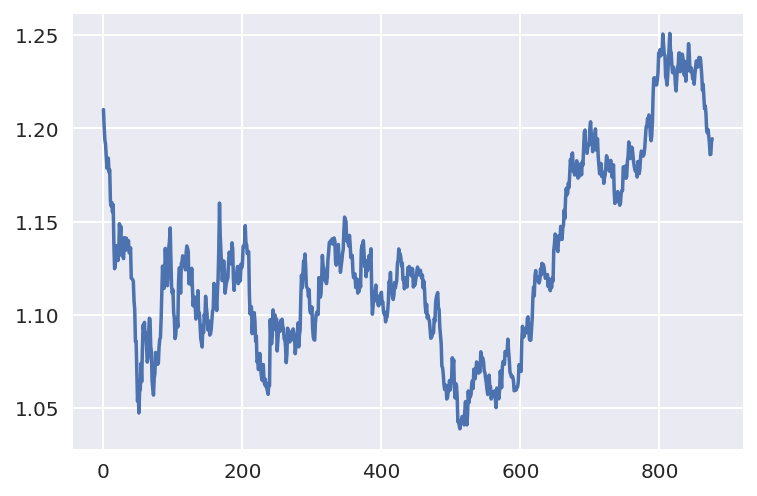

In [25]:
df_fx_usd_eur['FX_USD.EUR'].plot()

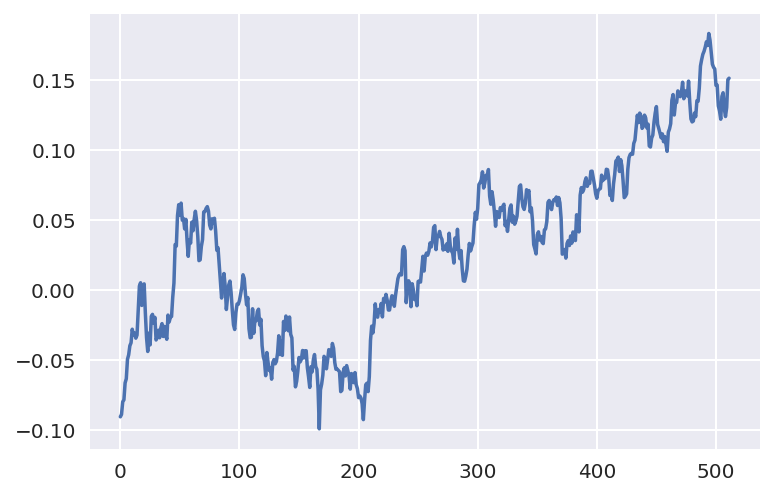

In [40]:
X = df_fx_usd_eur['FX_USD.EUR']
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
	value = X[i] - X[i - days_in_year]
	diff.append(value)
plt.plot(diff)
plt.show()

In [54]:
df_fx_usd_eur.index = df_fx_usd_eur['Dates']

            FX_USD.EUR
Dates                 
2015-01-31    1.163364
2015-02-28    1.135570
2015-03-31    1.081959
2015-04-30    1.082416
2015-05-31    1.115962
2015-06-30    1.123477
2015-07-31    1.099237
2015-08-31    1.114067
2015-09-30    1.123450
2015-10-31    1.121955
2015-11-30    1.072500
2015-12-31    1.090348
2016-01-31    1.086648


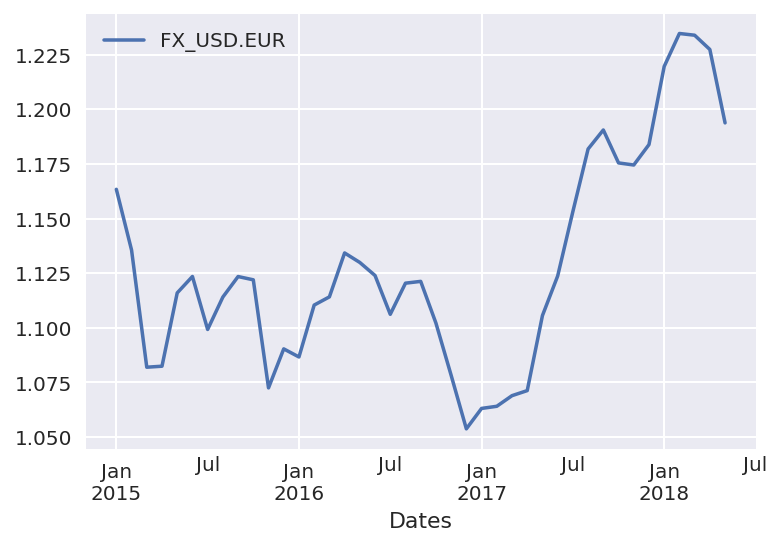

In [56]:
resample = df_fx_usd_eur.resample('M')
monthly_mean = resample.mean()
print(monthly_mean.head(13))
monthly_mean.plot()